In [1]:
# Updated script to show how to unpack information in pickled files 1/20/2025
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the files
species_dict_file = 'species_dict.pickle'
reaction_dict_file = 'reaction_dict.pickle'

thermo_uncertainty_file = 'thermo_cov.npy'
kinetics_uncertainty_file = 'kinetic_cov.npy'
overall_uncertainty_file = 'overall_cov.npy'

with open(species_dict_file, 'rb') as f:
    species_info_dict = pickle.load(f)
with open(reaction_dict_file, 'rb') as f:
    reaction_info_dict = pickle.load(f)

thermo_cov = np.load(thermo_uncertainty_file)
kinetics_cov = np.load(kinetics_uncertainty_file)
overall_cov = np.load(overall_uncertainty_file)

In [3]:
def get_thermo_from_NASA(NASA0, NASA1, T):
    # compute thermo properties from nasa polynomials  units are Joules and mols
    # NASA0 is the lower temperature range and NASA1 is the higher
    # expecting NASA polynomials in the following dictionary format:
#     {'coeffs': array([ 3.53732118e+00, -1.21570202e-03,  5.31615358e-06, -4.89440364e-09,
#          1.45843807e-12, -1.03858843e+03,  4.68368633e+00]),
#      'Tmin': (100,'K'),
#      'Tmax': (1074.56,'K')}
    
    assert T >= NASA0['Tmin']
    assert T <= NASA1['Tmax']
    
    a_low = NASA0['coeffs']
    a_high = NASA1['coeffs']
    
    if T < NASA0['Tmax']:
        cp = a_low[0] + a_low[1] * T + a_low[2] * T**2.0 + a_low[3] * T**3.0 + a_low[4] * T**4.0
        h = a_low[0] * T + a_low[1] / 2.0 * T**2.0 + a_low[2] / 3.0 * T**3.0 + a_low[3] / 4.0 * T**4.0 + a_low[4] / 5.0 * T**5.0 + a_low[5]
        s = a_low[0] * np.log(T) + a_low[1] * T + a_low[2] / 2.0 * T**2.0 + a_low[3] / 3.0 * T**3.0 + a_low[4] / 4.0 * T**4.0 + a_low[6]
    else:
        cp = a_high[0] + a_high[1] * T + a_high[2] * T**2.0 + a_high[3] * T**3.0 + a_high[4] * T**4.0
        h = a_high[0] * T + a_high[1] / 2.0 * T**2.0 + a_high[2] / 3.0 * T**3.0 + a_high[3] / 4.0 * T**4.0 + a_high[4] / 5.0 * T**5.0 + a_high[5]
        s = a_high[0] * np.log(T) + a_high[1] * T + a_high[2] / 2.0 * T**2.0 + a_high[3] / 3.0 * T**3.0 + a_high[4] / 4.0 * T**4.0 + a_high[6]

    R = 8.314472
    cp *= R
    h *= R
    s *= R

    return cp, h, s

## Look at the species in the mechanism

In [4]:
print(f'Index\t{"Species Label" + " " * (20 - len("Species Label"))}\tVar(H) (kcal/mol)^2')
for i, spec_key in enumerate(species_info_dict.keys()):
    print(f'{i}\t{spec_key + " " * (20 - len(spec_key))}\t{thermo_cov[i, i]}')

Index	Species Label       	Var(H) (kcal/mol)^2
0	CH2X_1              	47.858724
1	HOX_3               	47.858724
2	CHX_1               	47.858724
3	CX_1                	47.858724
4	OX_1                	47.858724
5	HCOX_3              	47.858724
6	H2O*                	47.858724
7	CH4*                	47.858724
8	HCCH                	2.29
9	X_3                 	47.858724
10	H2CCH2              	2.29
11	H2CO                	2.26
12	H2                  	2.25
13	NO                  	2.25
14	H2O                 	2.25
15	CO2                 	2.26
16	CH4                 	2.25
17	CC_2X               	50.148724
18	CCH_2X              	50.138724
19	HCCH_2X             	47.858724
20	HCCH2_2X            	47.858724
21	HOCXO_1             	47.858724
22	NH2_X               	47.858724
23	NHX_2               	47.858724
24	HCOO*               	47.858724
25	CH3O2*              	47.858724
26	H2CCH2_2X           	47.858724
27	H2CO_2X             	47.858724
28	HCOOH*              	47.858724
29	H2CCH3_X      

In [5]:
# Example get thermo at 1000K
T = 1000
my_species_label = 'CH2X_1'
NASA0 = species_info_dict[my_species_label]['NASA0']
NASA1 = species_info_dict[my_species_label]['NASA1']

cp, h, s = get_thermo_from_NASA(NASA0, NASA1, T)
print(h)  # in J/mol

33366.704582689425


Text(0.5, 1.0, 'Thermo Covariance (kcal/mol)^2')

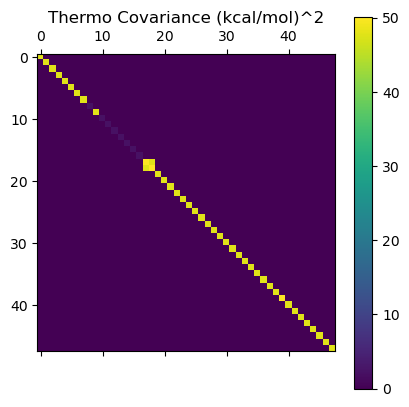

In [6]:
# plot the thermo covariance
plt.matshow(thermo_cov)
plt.colorbar()
plt.title('Thermo Covariance (kcal/mol)^2')
# plt.clim([0, 0.01])  # uncomment this to zoom in and see off-diagonals better

# Look at the Reactions in the File

In [7]:
print(f'Index\t{"Reaction Label" + " " * (40 - len("Reaction Label"))}\tVar(ln k)')
for i, reaction_key in enumerate(reaction_info_dict.keys()):
    print(f'{i}\t{reaction_key + " " * (40 - len(reaction_key))}\t{kinetics_cov[i, i]}')

Index	Reaction Label                          	Var(ln k)
0	CH2X_1 + HOX_3 <=> CH3X_4 + OX_1        	20.669927484651602
1	CHX_1 + HOX_3 <=> CH2X_1 + OX_1         	20.669927484651602
2	CX_1 + HOX_3 <=> CHX_1 + OX_1           	20.669927484651602
3	OX_1 + HCOX_3 <=> HOX_3 + COX_5         	56.867651084627724
4	H2O* + OX_1 <=> HOX_3 + HOX_3           	78.28475874027181
5	CH4* + OX_1 <=> CH3X_4 + HOX_3          	56.867651084627724
6	HCCH + X_3 + X_3 <=> HCCH_2X            	7.320280999999999
7	H2CCH2 + X_3 + X_3 <=> H2CCH2_2X        	7.320280999999999
8	H2CO + X_3 + X_3 <=> H2CO_2X            	7.320280999999999
9	H2 + X_3 + X_3 <=> HX_3 + HX_3          	7.320280999999999
10	NO + X_3 <=> NO_X                       	7.320280999999999
11	H2O + X_3 <=> H2O*                      	14.033435773339525
12	CO2 + X_3 <=> CO2X                      	14.033435773339525
13	CH4 + X_3 <=> CH4*                      	14.033435773339525
14	CC_2X <=> CX_1 + CX_1                   	7.320280999999999
15	CCH_2X <=> C

In [8]:
# see the info for a given reaction
reaction_info_dict['H2COX_vdW + X_3 <=> H2CO_2X']

{'index': 90,
 'parameterization': "<class 'rmgpy.kinetics.surface.SurfaceArrheniusBEP'>",
 'kinetics': {'A': 1.78e+21,
  'n': 0.0,
  'alpha': 0.0,
  'E0': 12.0,
  'A_units': 'cm^2/(mol*s)',
  'E0_units': 'kJ/mol'},
 'comment': 'Exact match found for rate rule [Combined;VacantSite]\nEuclidian distance = 0\nfamily: Surface_vdW_to_Bidentate',
 'reactants': ['H2COX_vdW', 'X_3'],
 'products': ['H2CO_2X']}

Text(0.5, 1.0, 'Kinetics (ln k) Covariance')

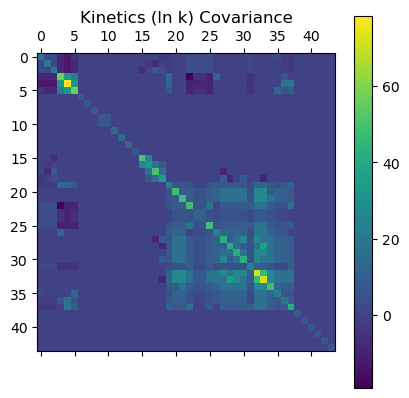

In [9]:
# plot the kinetics covariance
plt.matshow(kinetics_cov)
plt.colorbar()
plt.title('Kinetics (ln k) Covariance')
# plt.clim([-0.01, 0.01])  # uncomment this to zoom in and see off-diagonals better

# plot the overall combined thermo/kinetics covariance matrix

Text(0.5, 1.0, 'Combined Thermo/Kinetic Covariance')

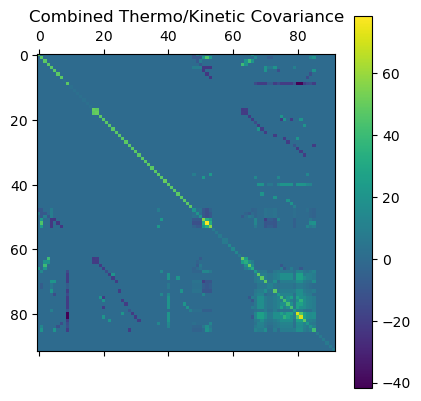

In [10]:
# plot the overall covariance -- species in top left, reactions in bottom right
plt.matshow(overall_cov)
plt.colorbar()
plt.title('Combined Thermo/Kinetic Covariance')
# plt.clim([-0.01, 0.01])  # uncomment this to zoom in and see off-diagonals better